Reproduce: Analytic
=================

## Simulating Secondary Magnetic Field Data over a Conductive Sphere

Secondary magnetic fields are simulated over conductive sphere in a vacuum. The sphere has a conductivity of $\sigma$ = 1 S/m. The center of the sphere is located at (0,0,-50) and has a radius of $a$ = 8 m.

Secondary magnetic fields are simulated for an x, y and z oriented magnetic dipoles sources at (-5,0,10). The x, y and z components of the response are simulated for each source at (5,0,10). We plot only the horizontal coaxial, horizontal coplanar and vertical coplanar data.

## Package Details

Wait and Spies analytic solution. See https://em.geosci.xyz/content/maxwell3_fdem/inductive_sources/sphere/index.html for a summary of the solution.

*Reference:* J. R. Wait. A conductive sphere in a time varying magnetic field. Geophysics, 16:666–672, 1951.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from SimPEG.utils import mkvc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({"font.size": 10})
write_output = True

Here we define the sphere model.

In [2]:
rootdir = './../../../assets/fdem/sphere_vacuum_conductive_fwd_simpeg/'

a = 8                                # radius of sphere
sig0 = 1e-8                          # background conductivity
sig = 1e0                            # electrical conductivity of sphere
chi = 0.                             # relative permeability of sphere
xyzs = [0., 0., -50.]                # xyz location of the sphere

mur = 1 + chi

Here, we define the survey geometry for the forward simulation.

In [3]:
xyz_tx = np.c_[-5., 0., 10.]         # Transmitter location
xyz_rx = np.c_[5., 0., 10.]          # Receiver location
frequencies = np.logspace(2,5,10)    # Frequencies
tx_moment = 1.                       # Dipole moment of the transmitter

Here we define some functions that are used to compute the analytic forward solution.

In [4]:
def compute_primary_field_dipole(orientation, pxyz, qxyz):
    """
    For an X, Y or Z orientationed magnetic dipole, compute the free-space primary field for a dipole moment of 1.
    
    orientation: 'x', 'y' or 'z'
    pxyz : [x,y,z] locations of the dipole transmitters
    qxyz : [x,y,z] location at the centre location of the sphere
    
    """

    R = np.sqrt((qxyz[0] - pxyz[:,0]) ** 2 + (qxyz[1] - pxyz[:,1]) ** 2 + (qxyz[2] - pxyz[:,2]) ** 2)

    if orientation == "x":
        Hpx = (1 / (4 * np.pi)) * (3 * (qxyz[0] - pxyz[:,0]) * (qxyz[0] - pxyz[:,0]) / R ** 5 - 1 / R ** 3)
        Hpy = (1 / (4 * np.pi)) * (3 * (qxyz[1] - pxyz[:,1]) * (qxyz[0] - pxyz[:,0]) / R ** 5)
        Hpz = (1 / (4 * np.pi)) * (3 * (qxyz[2] - pxyz[:,2]) * (qxyz[0] - pxyz[:,0]) / R ** 5)
    elif orientation == "y":
        Hpx = (1 / (4 * np.pi)) * (3 * (qxyz[0] - pxyz[:,0]) * (qxyz[1] - pxyz[:,1]) / R ** 5)
        Hpy = (1 / (4 * np.pi)) * (3 * (qxyz[1] - pxyz[:,1]) * (qxyz[1] - pxyz[:,1]) / R ** 5 - 1 / R ** 3)
        Hpz = (1 / (4 * np.pi)) * (3 * (qxyz[2] - pxyz[:,2]) * (qxyz[1] - pxyz[:,1]) / R ** 5)
    elif orientation == "z":
        Hpx = (1 / (4 * np.pi)) * (3 * (qxyz[0] - pxyz[:,0]) * (qxyz[2] - pxyz[:,2]) / R ** 5)
        Hpy = (1 / (4 * np.pi)) * (3 * (qxyz[1] - pxyz[:,1]) * (qxyz[2] - pxyz[:,2]) / R ** 5)
        Hpz = (1 / (4 * np.pi)) * (3 * (qxyz[2] - pxyz[:,2]) * (qxyz[2] - pxyz[:,2]) / R ** 5 - 1 / R ** 3)

    return np.c_[Hpx, Hpy, Hpz]


def compute_excitation_factor(f, sig, mur, a):
    """
    Compute Excitation Factor (FEM)
    
    f : frequencies
    sig : conductivity
    mur : relative permeability
    a : radius
    """

    w = 2 * np.pi * f
    mu = 4 * np.pi * 1e-7 * mur
    alpha = a * np.sqrt(1j * w * mu * sig)

    chi = (
        1.5
        * (
            2 * mur * (np.tanh(alpha) - alpha)
            + (alpha ** 2 * np.tanh(alpha) - alpha + np.tanh(alpha))
        )
        / (
            mur * (np.tanh(alpha) - alpha)
            - (alpha ** 2 * np.tanh(alpha) - alpha + np.tanh(alpha))
        )
    )

    return chi


def compute_dipolar_response(m, pxyz, qxyz):
    """
    For a sphere with dipole moment [mx, my, mz], compute the dipolar response
    
    m : dipole moments [mx, my, mz]
    orientation of the receiver: 'x', 'y' or 'z'
    pxyz : [x,y,z] locations of the receivers
    qxyz : [x,y,z] location at the centre location of the sphere
    
    """

    R = np.sqrt((qxyz[0] - pxyz[:,0]) ** 2 + (qxyz[1] - pxyz[:,1]) ** 2 + (qxyz[2] - pxyz[:,2]) ** 2)

    Hx = (1 / (4 * np.pi)) * ( 3 * (pxyz[:,0] - qxyz[0]) * (
                m[:,0]*(pxyz[:,0] - qxyz[0]) +
                m[:,1]*(pxyz[:,1] - qxyz[1]) +
                m[:,2]*(pxyz[:,2] - qxyz[2])
            ) / R ** 5 - m[:,0] / R ** 3)

    Hy = (1 / (4 * np.pi)) * ( 3 * (pxyz[:,1] - qxyz[1]) * (
                m[:,0]*(pxyz[:,0] - qxyz[0]) +
                m[:,1]*(pxyz[:,1] - qxyz[1]) +
                m[:,2]*(pxyz[:,2] - qxyz[2])
            ) / R ** 5 - m[:,1] / R ** 3)

    Hz = (1 / (4 * np.pi)) * ( 3 * (pxyz[:,2] - qxyz[2]) * (
                m[:,0]*(pxyz[:,0] - qxyz[0]) +
                m[:,1]*(pxyz[:,1] - qxyz[1]) +
                m[:,2]*(pxyz[:,2] - qxyz[2])
            ) / R ** 5 - m[:,2] / R ** 3)

    return np.c_[Hx, Hy, Hz]

Finally, we predict the secondary magnetic field data for the model provided.

In [5]:
Hs_analytic = []

for ii, comp in enumerate(['x','y','z']):
    
    # Compute the free space primary field at the location of the sphere
    Hp = tx_moment*compute_primary_field_dipole(comp, xyz_tx, xyzs)
    
    temp = []
    for jj in range(0, len(frequencies)):

        # Multiply by the excitation factor to get the dipole moment of the sphere
        m = (4*np.pi*a**3/3)*compute_excitation_factor(frequencies[jj], sig, mur, a) * Hp

        # Compute dipolar response
        temp.append(compute_dipolar_response(m, xyz_rx, xyzs))

    Hs_analytic.append(np.vstack(temp))

We can export the data to a simple text file.

In [6]:
if write_output:
    
    fname_analytic = rootdir + 'analytic.txt'
    
    header = 'FREQUENCY HX_REAL HX_IMAG HY_REAL HY_IMAG HZ_REAL HZ_IMAG'
    f_column = np.kron(np.ones(3), frequencies)
    
    out_array = np.vstack(Hs_analytic)
    out_array = np.c_[
        f_column,
        np.real(out_array[:, 0]),
        np.imag(out_array[:, 0]),
        np.real(out_array[:, 1]),
        np.imag(out_array[:, 1]),
        np.real(out_array[:, 2]),
        np.imag(out_array[:, 2])
    ]

    fid = open(fname_analytic, 'w')
    np.savetxt(fid, out_array, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Simulated Data Plot

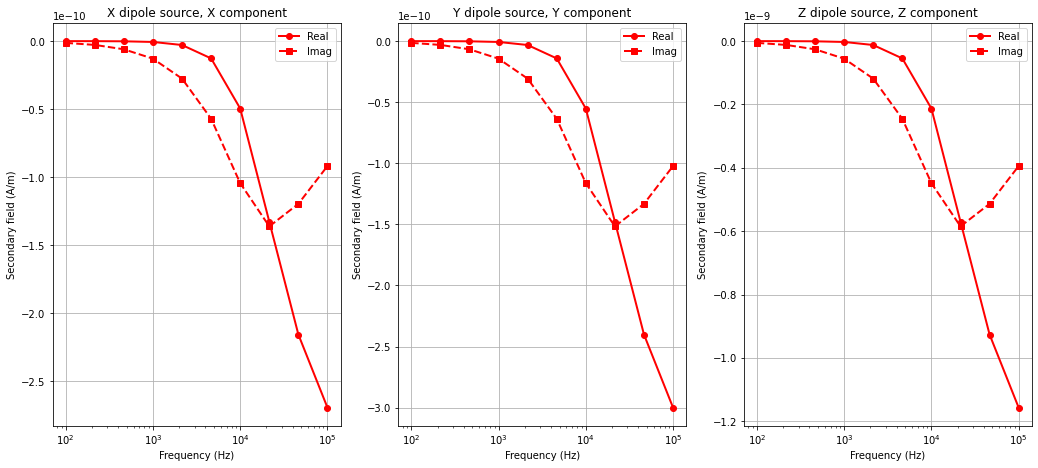

In [7]:
fig = plt.figure(figsize=(16, 7))
lw = 2
ms = 6

ax = 3*[None]

legend_str = ['Real', 'Imag']

for ii, src in enumerate(['X','Y','Z']):
    
        ax[ii] = fig.add_axes([0.05 + 0.3*ii, 0.1, 0.25, 0.8])
        ax[ii].semilogx(frequencies, np.real(Hs_analytic[ii][:, ii]), 'r-o', lw=lw, markersize=ms)
        ax[ii].semilogx(frequencies, np.imag(Hs_analytic[ii][:, ii]), 'r--s', lw=lw, markersize=ms)
        ax[ii].grid()
        ax[ii].set_xlabel('Frequency (Hz)')
        ax[ii].set_ylabel('Secondary field (A/m)')
        ax[ii].set_title(src + ' dipole source, ' + src + ' component')
        ax[ii].legend(legend_str)